# ENSO_pattern: zonal structure of boreal winter SST anomalies in the equatorial Pacific

Computes the zonal root mean square error (RMSE) of boreal winter (December) sea surface temperature anomalies (SSTA) along the equatorial Pacific (150°E–90°W), averaged meridionally over 5°S–5°N. Observations and model outputs are compared after processing, including smoothing with a 5-month triangular-weighted moving average.

## Datasets Used for SSTA Comparison
The following reference datasets are employed to evaluate the ENSO-related SST patterns in model simulations:

- **TropFlux** (1979–2018): The primary dataset for comparison, providing high-quality estimates of surface fluxes and anomalies designed for tropical ocean and climate studies, combining in-situ measurements with satellite-derived data.
Additional datasets include:

- **20CRv2** (1871–2012): A century-scale reanalysis leveraging surface pressure observations to reconstruct global atmospheric conditions.- **ERA-Interim** (1979–2018): A widely used reanalysis dataset offering high-resolution estimates of atmospheric and surface variables with robust data assimilation techniques.
- **ERSSTv5** (1854–2018): A globally gridded dataset of historical SSTs derived from in-situ measurements and optimised for climate monitoring and ENSO studies.
- **HadISST** (1870–2018): A long-term SST and sea ice dataset combining ship and buoy observations with historical data reconstruction.
- **NCEP2** (1979–2018): The second-generation reanalysis dataset from NCEP, improving upon the earlier version for global atmospheric and oceanic variability analysis.

## Dask Cluster 

Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client, progress
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42101,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:46265,Total threads: 3
Dashboard: /proxy/39963/status,Memory: 11.50 GiB
Nanny: tcp://127.0.0.1:38137,


## Datasets

In [20]:
from esmvalcore.dataset import Dataset
from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2')

In [21]:
model_datasets = {
"ACCESS-CM2": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-CM2",
    grid="gn"
),
## Note: It is possible to use tos (sea_surface_temperature; degC; ocean; mon) 
# "ACCESS-CM2": 
#     Dataset(
#     short_name='tos',
#     project='CMIP6',
#     mip="Omon",
#     exp="historical",
#     ensemble="r1i1p1f1",
#     timerange="18500101/20190101",
#     dataset="ACCESS-CM2",
#     grid="gn"
# )
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
"ERA-Interim":
    Dataset(
    short_name='ts',
    dataset='ERA-Interim',
    mip="Amon",
    project='OBS6',
    type='reanaly',
    tier=3),
}

## Add Ancillary files

In [22]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [23]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/esmvalcore/config/_config_valid

In [9]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np


In [10]:
## pattern enso, eq
def sst_enso(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = extract_region(cube, **nino34_latext_region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    # smooth once
    # cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')
    cube = extract_month(cube,12) # get DEC
    #remove time mean
    cube = anomalies(cube,period='monthly')
    return cube

def sst_eq(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    # cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube,12) # get DEC
    # remove time mean
    cube = anomalies(cube, period='monthly')
    cube = meridional_statistics(cube, 'mean')

    return cube

def lin_regress_1d(cube_ssta, cube_nino34):
    A_data = cube_ssta.data #.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    B_data = cube_nino34.data.flatten()  # Shape (time,)
    
    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    return cube_ssta.coord('longitude').points, coefs[0]


In [11]:
def sst_eq2(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    # cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube,12) # get DEC
    cube = anomalies(cube, period='monthly')
    return cube


In [12]:
def lin_regress_matrix(cubeA, cubeB): #array must not contain infs or NaNs
    """
    Calculate the linear regression of cubeA on cubeB using matrix operations.

    Parameters
    ----------
    cubeA: iris.cube.Cube
        The 2D input cube for which the regression is calculated.
    
    cubeB: iris.cube.Cube
        The cube used as the independent variable in the regression.

    Returns
    -------
    iris.cube.Cube
        A new cube containing the slope of the regression for each spatial point.
    """
    # Get data as flattened arrays
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    B_data = cubeB.data.flatten()  # Shape (time,)

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    
    # Extract slopes from coefficients #coefs 1
    slopes = coefs[0].reshape(cubeA.shape[1], cubeA.shape[2])

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(slopes, long_name='regression ENSO SSTA',
                                 dim_coords_and_dims=[(cubeA.coord('latitude'), 0),
                                                      (cubeA.coord('longitude'), 1)])

    return result_cube

In [24]:
model_datasets_prep1 = {name: sst_enso(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: sst_eq(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep3 = {name: sst_eq2(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_enso(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: sst_eq(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep3 = {name: sst_eq2(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/iris/cube.py:4341: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBoundsWar

# Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the main differences between the model and the reference.

In [25]:
## linear regression sst_eq on sst_enso
reg_mod = lin_regress_1d(model_datasets_prep2["ACCESS-CM2"], model_datasets_prep1["ACCESS-CM2"])

reg = lin_regress_1d(obs_datasets_prep2["ERA-Interim"], obs_datasets_prep1["ERA-Interim"])

Text(0.5, 0.95, 'RMSE: 0.07 ')

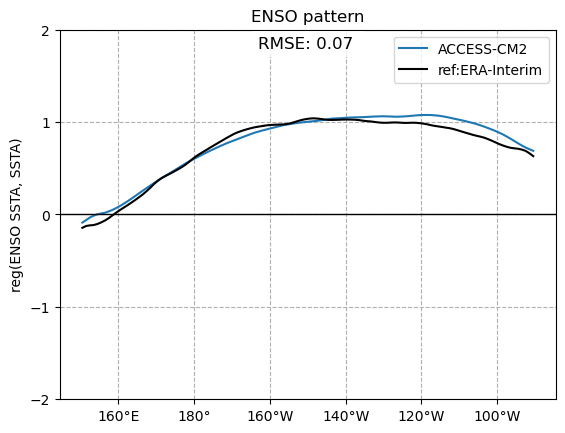

In [26]:

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

plt.plot(reg_mod[0], reg_mod[1], label="ACCESS-CM2") #units

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

plt.plot(reg[0],reg[1], color='black',label='ref:ERA-Interim')

plt.yticks(np.arange(-2,3, step=1))
plt.axhline(y=0, color='black', linewidth=1)
plt.ylabel("reg(ENSO SSTA, SSTA)")
plt.title('ENSO pattern') #
plt.legend()
plt.grid(linestyle='--')

rmse = np.sqrt(np.mean((np.array(reg[1]) - np.array(reg_mod[1])) ** 2)) #metric

plt.text(0.5, 0.95, f"RMSE: {rmse:.2f} ", fontsize=12, ha='center', transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

**Figure 1**: Zonal structure of sea surface temperature anomalies (SSTA) in the equatorial Pacific (averaged between 5°S and 5°N). The figure highlights the zonal distribution of SSTA associated with ENSO, which is typically overestimated west of the dateline; in this case, the anomalies are too strong in the central Pacific. The black curve represents the reference data, while the blue curve corresponds to the model output. The derived metric is the zonal root mean square error (RMSE) between the model and reference curves.

## Diagnostic Level 2

The second level shows the broader picture to better understand the spatial pattern of ENSO: the map of the anomalies in the equatorial Pacific.


In [27]:
reg2_mod = lin_regress_matrix(model_datasets_prep3["ACCESS-CM2"], model_datasets_prep1["ACCESS-CM2"])
reg2_obs = lin_regress_matrix(obs_datasets_prep3["ERA-Interim"], obs_datasets_prep1["ERA-Interim"])
#make dict process
process = {"ACCESS-CM2":reg2_mod , "ERA-Interim":reg2_obs} 

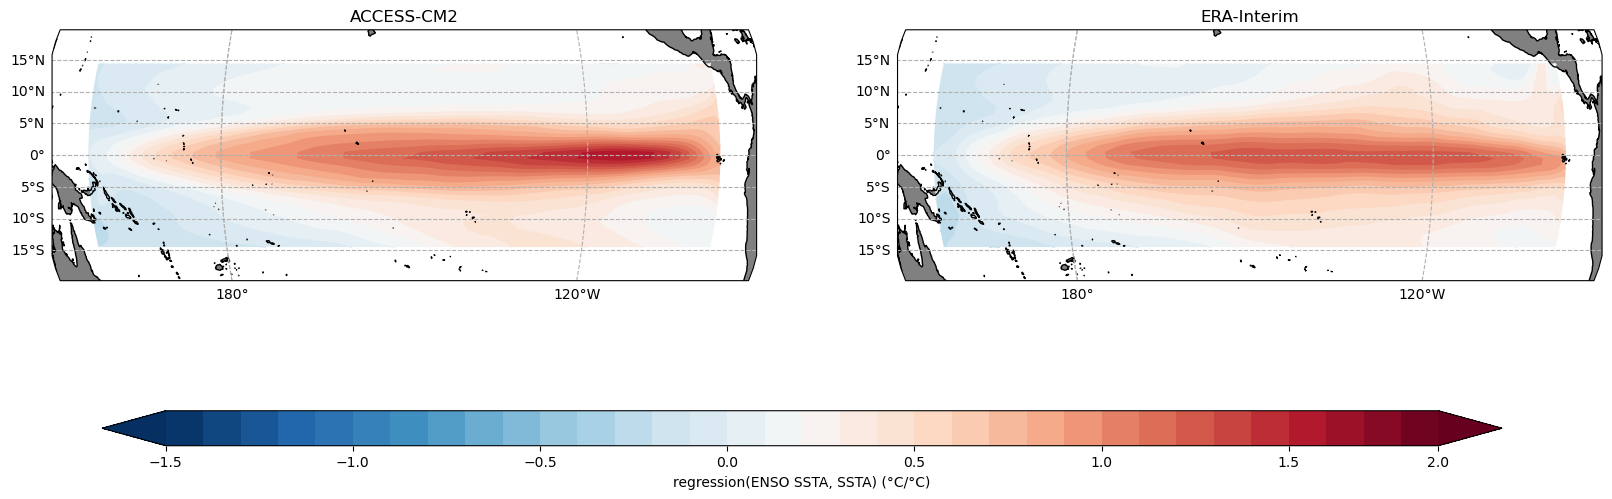

In [28]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.Orthographic(central_longitude=210.0)
i =121
# process = {**model_datasets_prep3, **obs_datasets_prep3}


for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-1.5,2,0.1),extend='both', cmap='RdBu_r')
    # cf1 = plt.contourf(reg2[0],reg2[1],reg2[2], cmap='RdBu_r', levels=np.arange(0,2,0.1))

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label)

    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False

    i+=1


# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-1.5,2.5,0.5))
cbar.set_label('regression(ENSO SSTA, SSTA) (°C/°C)')

Figure 2: sea surface temperature anomalies (SSTA) associated with ENSO in the equatorial Pacific, showing usually the SSTA too far west (here too strong in the central Pacific). The left and right maps show respectively the reference and the model.

## Diagnostic level 3

In [18]:
from esmvalcore.preprocessor import (
                        mask_above_threshold, mask_below_threshold)
def mask_to_years(events):
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]
    
def enso_events(cube):
    # print(cube.data.std())
    cb_stdev = cube.data.std()
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75*cb_stdev))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75*cb_stdev))
    
    return {'nina':a_events, 'nino':o_events}

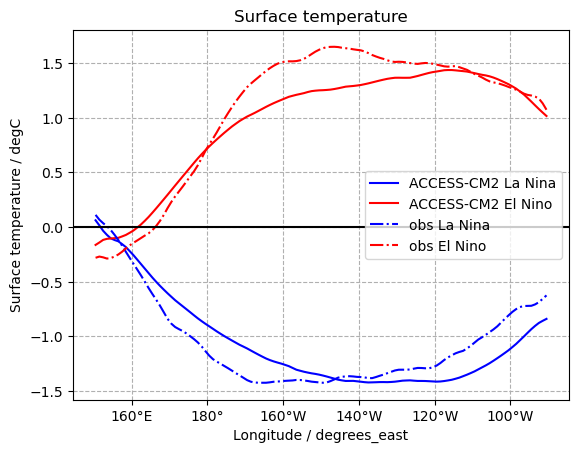

In [29]:
#extract out years matching enso events

def plot_enso_ssta(prep_datasets, line, label):
    events = enso_events(prep_datasets[1])
    for enso, years in events.items():
        
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in years)
        cube_2 = prep_datasets[0].extract(year_enso)
        cube = climate_statistics(cube_2, operator='mean')

        if enso == 'nina': ## plot separate
            qplt.plot(cube, color='blue', linestyle=line, label=f"{label} La Nina")
        else:
            qplt.plot(cube, color='red', linestyle=line, label=f"{label} El Nino")


prep_datasets = [model_datasets_prep2["ACCESS-CM2"], model_datasets_prep1["ACCESS-CM2"]] #sst_enso

plot_enso_ssta(prep_datasets,'solid', 'ACCESS-CM2')
plot_enso_ssta([obs_datasets_prep2["ERA-Interim"], obs_datasets_prep1["ERA-Interim"]],'dashdot', 'obs')

plt.grid(linestyle='--')
plt.axhline(y=0, color='black', linewidth=1.5)
plt.legend()
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

Figure 3: sea surface temperature anomalies (SSTA) during La Niña and El Niño in the equatorial Pacific, showing usually the slightly too weak SSTA and reaching too far west (here not negative enough in the western Pacific for La Niña and almost perfect for El Niño). The blue and red curves show respectively La Niña composite and the El Niño composite, dashed and solid lines show respectively the reference and the model.

## Diagnostic level 4

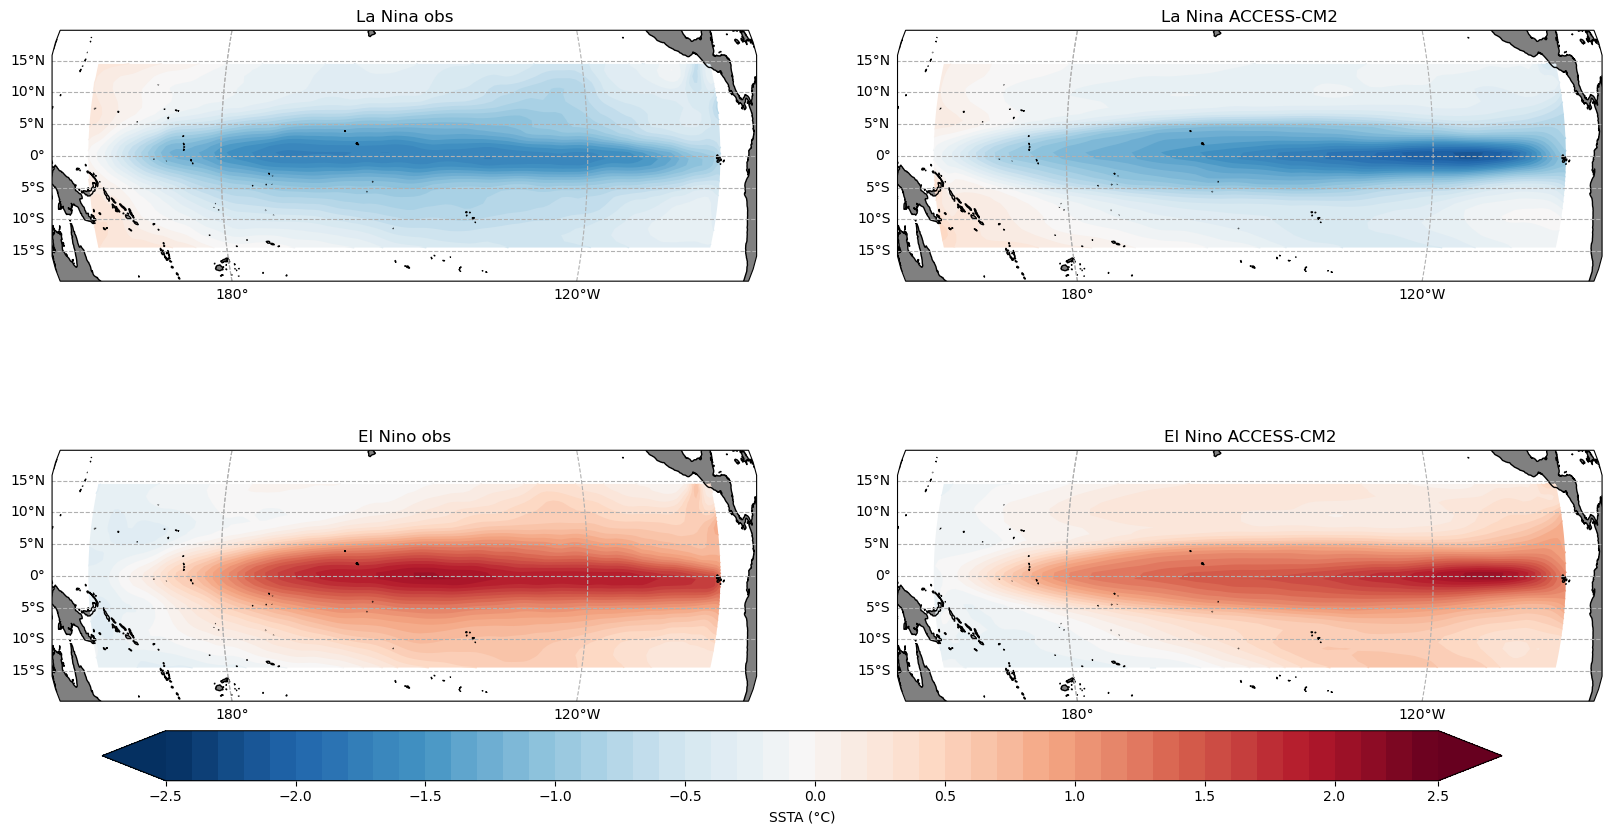

In [31]:
#enso events, 
def plot_ensofig(i, cube, label):
    ax1 = plt.subplot(i, projection=ccrs.Orthographic(central_longitude=210.0))
    ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
    ax1.coastlines()
    cf2 = iplt.contourf(cube, levels=np.arange(-2.5,2.5,0.1),extend='both', cmap='RdBu_r')

    ax1.set_extent([130, 290, -20, 20], crs=ccrs.PlateCarree())
    ax1.set_title(label) #
    # Add gridlines for latitude and longitude
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    return i+2, cf2

def enso_regression(prep_datasets, i, label):
    events = enso_events(prep_datasets[1])
    for enso, years in events.items():
        
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in years)
        cube_2 = prep_datasets[0].extract(year_enso)
        cube = climate_statistics(cube_2, operator='mean')
        if enso == 'nina': ## plot separate
            i, cf = plot_ensofig(i, cube, f'La Nina {label}')
        else:
            i, cf = plot_ensofig(i, cube, f'El Nino {label}')
    return cf

fig = plt.figure(figsize=(20, 10))
i = 221 # nina top row
enso_regression([obs_datasets_prep3["ERA-Interim"], obs_datasets_prep1["ERA-Interim"]], i, 'obs')
i = 222
cf = enso_regression([model_datasets_prep3["ACCESS-CM2"], model_datasets_prep1["ACCESS-CM2"]], i, 'ACCESS-CM2')

# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-2.5,2.6,0.5))
cbar.set_label('SSTA (°C)')

Figure 4: sea surface temperature anomalies (SSTA) during La Niña and El Niño in the equatorial Pacific, showing mainly the SSTA too far west (here SSTA not strong enough in the western Pacific for La Niña and SSTA not spread enough in latitude for El Niño). The left and right maps show respectively the reference and the model. The first and second rows show respectively the La Niña composites and the El Niño composites.